# Optimizer Example
Jena Climate CNN example showing comparison between Adam and other optimizers available when it was introduced.
This is a regression model, using 3-hour data.

Richard Henry, 26-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
plt.style.use('fivethirtyeight')

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.17.0'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

|Dataset|Architecture|Group|Type|
|---|---|---|---|
|Jena 3hr|CNN|Contemporary|Regression|

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=(8*6)*8      #Look back at 7 weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=(16*6)*8      #batch size of 14 weeks
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,int(blk_len/6),col_len*6])
for i in range(cut_len):
    for j in range(blk_len):
        g=j//6              #Row position
        h=j%6               #Column offset
        for k in range(col_len):
            xTrain[i][g][h*col_len+k]=xAll[i+j][k]
xTrain = np.expand_dims(xTrain, -1) 

CPU times: total: 45.9 s
Wall time: 49 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model functions
def model_core():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(int(blk_len/6),col_len*6,1)),
            fixMe,
            tf.keras.layers.Conv2D(64, 
                                   kernel_size=(3, 3),
                                   strides=(1,1),
                                   padding='same',
                                   activation="relu"),
#            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#            tf.keras.layers.Conv2D(32, 
#                                   kernel_size=(3, 3),
#                                   padding='same',
#                                   activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, 
                                  activation="linear")
        ]
    )
    return model    
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model=model_core()
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    # Reduce variation in training...
    tf.random.set_seed(17)
    print("History Match:")
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    print("\n")
    print("Evaluate Model:")
    myEva=model.evaluate(xTrain,
                         y_train,
                         batch_size=bat_len)
    print("All Sample MSE:",myEva[0])
    print("All Sample MAE:",myEva[1])
    print("\n")
    print("Make Predictions:")
    myPre=model.predict(xTrain)
    print("\n")
    print("Timing:")
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build('adam')

History Match:
Epoch 1/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 475ms/step - loss: 90.8600 - mean_absolute_error: 7.7109 - val_loss: 80.6353 - val_mean_absolute_error: 7.2210
Epoch 2/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - loss: 69.6600 - mean_absolute_error: 6.8115 - val_loss: 69.3761 - val_mean_absolute_error: 6.7988
Epoch 3/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - loss: 68.1398 - mean_absolute_error: 6.7481 - val_loss: 69.9483 - val_mean_absolute_error: 6.8180
Epoch 4/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step - loss: 67.9964 - mean_absolute_error: 6.7406 - val_loss: 69.8879 - val_mean_absolute_error: 6.8133
Epoch 5/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - loss: 67.8205 - mean_absolute_error: 6.7311 - val_loss: 69.3416 - val_mean_absolute_error: 6.7898
Epoch 6/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - loss: 67.5432 - mean_absolute_error: 6.7166 - val_loss: 69.4687 - val_mean_absolute_error: 6.7893
Epoch 7/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - loss: 67.1760 - me

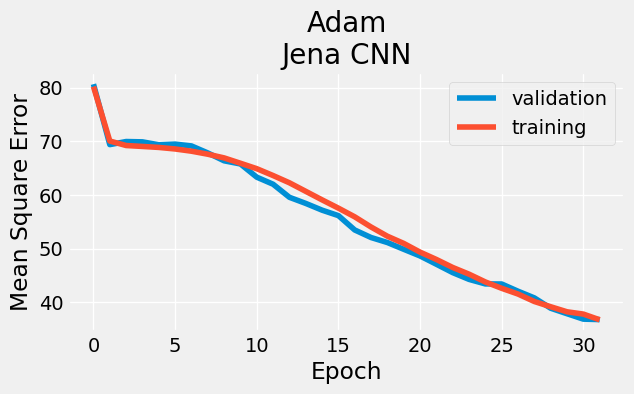

In [13]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(h0.history['val_loss'])
plt.plot(h0.history['loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam\nJena CNN')
plt.grid(color='white')
plt.show()

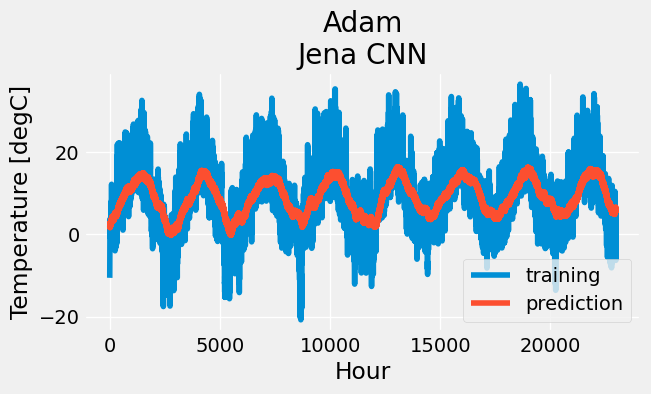

In [14]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(y_train)
plt.plot(p0.flatten())
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam\nJena CNN')
plt.grid(color='white')
plt.show()

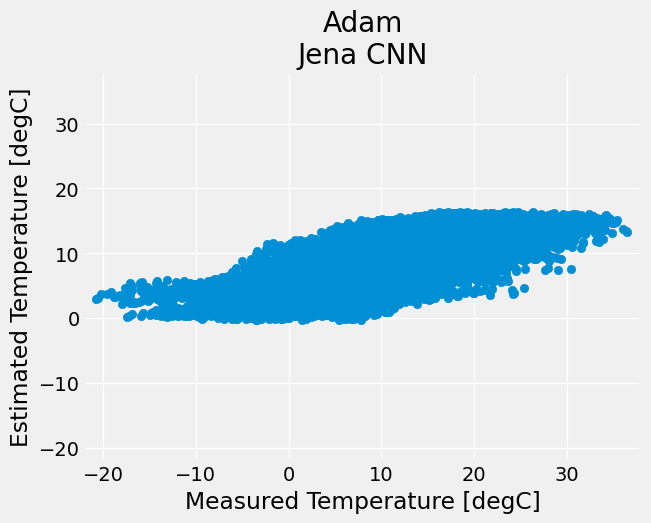

In [15]:
plt.figure(figsize=(13.33, 6.67))
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam\nJena CNN')
plt.grid(color='white')
plt.xlim([-22,38])
plt.ylim([-22,38])
plt.show()

### Second Model, AdaGrad

In [16]:
%%time
h1,p1=model_build('adagrad')

History Match:
Epoch 1/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - loss: 82.7129 - mean_absolute_error: 7.3595 - val_loss: 70.1491 - val_mean_absolute_error: 6.8284
Epoch 2/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - loss: 68.2862 - mean_absolute_error: 6.7567 - val_loss: 70.1347 - val_mean_absolute_error: 6.8271
Epoch 3/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - loss: 68.1987 - mean_absolute_error: 6.7518 - val_loss: 70.0879 - val_mean_absolute_error: 6.8246
Epoch 4/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step - loss: 68.1352 - mean_absolute_error: 6.7494 - val_loss: 70.0207 - val_mean_absolute_error: 6.8214
Epoch 5/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - loss: 68.1106 - mean_absolute_error: 6.7472 - val_loss: 69.9992 - val_mean_absolute_error: 6.8200
Epoch 6/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step - loss: 68.0869 - mean_absolute_error: 6.7463 - val_loss: 69.9257 - val_mean_absolute_error: 6.8165
Epoch 7/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - loss: 68.051

### Third Model, Stochastic Gradient Descent with Nesterov Momentum

In [17]:
opt012=tf.keras.optimizers.SGD(momentum=0.5,
                               nesterov=True,
                               name='nSGD'
                              )

In [18]:
%%time
h2,p2=model_build(opt012)

History Match:
Epoch 1/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 502ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 627ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 495ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 8/32
2

### Fourth Model, Root Mean Squared Propagation

In [19]:
%%time
h3,p3=model_build('rmsprop')

History Match:
Epoch 1/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - loss: 101.0962 - mean_absolute_error: 8.0966 - val_loss: 66.8425 - val_mean_absolute_error: 6.7437
Epoch 2/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - loss: 72.8316 - mean_absolute_error: 6.9385 - val_loss: 69.3352 - val_mean_absolute_error: 6.7955
Epoch 3/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - loss: 71.7667 - mean_absolute_error: 6.8975 - val_loss: 73.6888 - val_mean_absolute_error: 6.9557
Epoch 4/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - loss: 72.6321 - mean_absolute_error: 6.9339 - val_loss: 65.9780 - val_mean_absolute_error: 6.6808
Epoch 5/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - loss: 70.1693 - mean_absolute_error: 6.8270 - val_loss: 70.1367 - val_mean_absolute_error: 6.8167
Epoch 6/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - loss: 69.7349 - mean_absolute_error: 6.8113 - val_loss: 65.5737 - val_mean_absolute_error: 6.6569
Epoch 7/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 426ms/step - loss: 69.35

### SGD with 'Regular' Momentum

In [20]:
opt015=tf.keras.optimizers.SGD(momentum=0.5,
                               nesterov=False,
                               name='mSGD'
                              )

In [21]:
%%time
h5,p5=model_build(opt015)

History Match:
Epoch 1/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 423ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 427ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 420ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 8/32
2

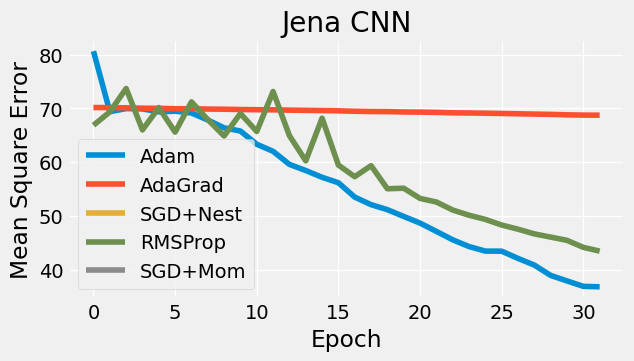

In [22]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(h0.history['val_loss'])
plt.plot(h1.history['val_loss'])
plt.plot(h2.history['val_loss'])
plt.plot(h3.history['val_loss'])
plt.plot(h5.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad','SGD+Nest','RMSProp','SGD+Mom'])
plt.title('Jena CNN')
plt.grid(color='white')
plt.show()

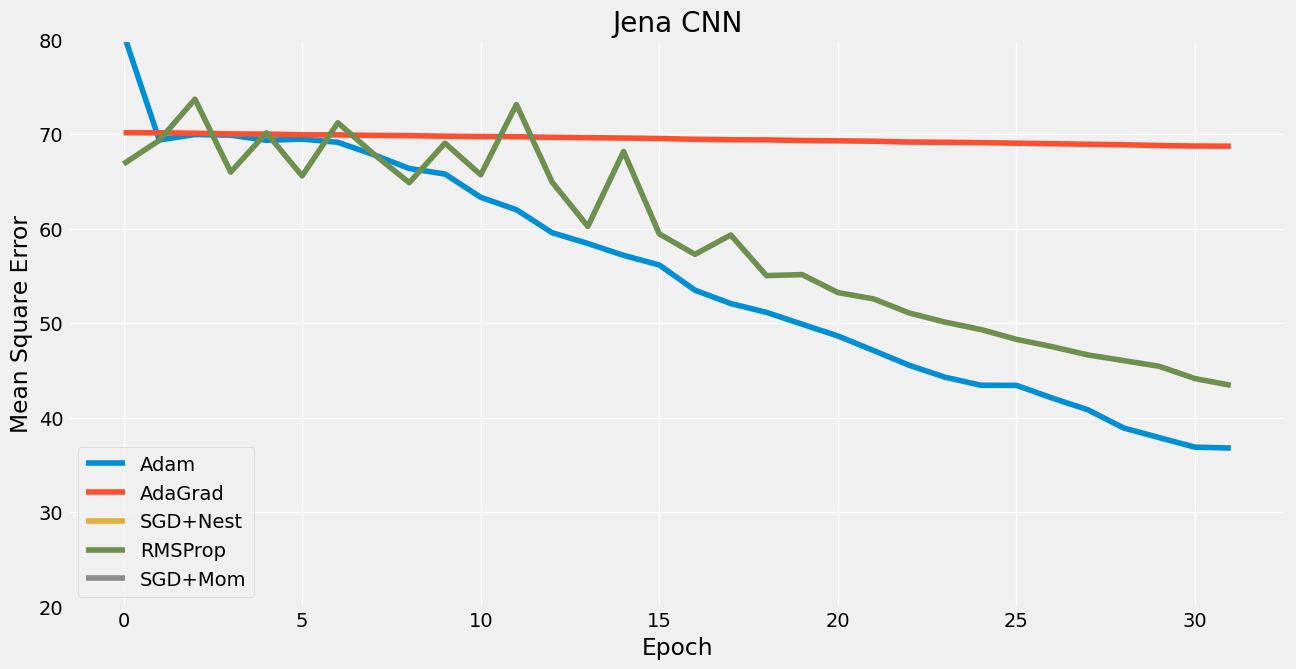

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(h0.history['val_loss'])
plt.plot(h1.history['val_loss'])
plt.plot(h2.history['val_loss'])
plt.plot(h3.history['val_loss'])
plt.plot(h5.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad','SGD+Nest','RMSProp','SGD+Mom'])
plt.title('Jena CNN')
plt.ylim([20,80])
plt.grid(color='white')
plt.show()

### Model Summary

In [24]:
m=model_core()
m.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 64, 66, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 66, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 33, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 67584)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 67584)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │          67,585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,228 (266.52 KB)

 Trainable params: 68,225 (266.50 KB)

 Non-trainable params: 3 (16.00 B)